In [1]:
# @author Matthew Sit

import numpy as np
import scipy.stats as stat
import os
from noisyopt import minimizeCompass
from scipy.optimize import minimize
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import operator
import pickle
from operator import itemgetter
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import csv
import h5py 

# Parameters that can be changed

In [6]:
# Data Files
opt_path = './optimization_results_path/opt_result_single_stim_bbp_full.hdf5'
params_path = './params_bbp_full.hdf5'
scores_path = './scores/'
params_file = h5py.File(params_path, 'r')
opt_result = h5py.File(opt_path, 'r')

In [7]:
# Constants 
coarseStepSize = 0.1
fineStepSize = 0.01

# Value in range [0, 1] reflecting percent of data to use for training.
# 1 - proportionToTrain will be used for validation.
proportionToTrain = 0.7

# Integer in range [1, len(stim_names)].
# The number of top stims to use for multi-stim optimization.
# If k = 1, then use the top stim only.
k = 20

# random seed to use for train/validation on optimization
seed = 500

# Weights for optimization.
# obj_comb_vec is vector of weights for [spearman, mean, standard deviation].
# In general, we want to maximize spearman, maximize mean, and minimize standard deviation.

score_function_list = [e.decode('ascii') for e in opt_result['ordered_score_function_list'][:]]

In [8]:
# Dump these parameters to a pickle file so that
# they can be used by the utility script file
# when it is run in the next section.

with open("params.pkl", 'wb') as f:
    pickle.dump([
        scores_path,
        params_path,
        score_function_list,
        coarseStepSize,
        fineStepSize
    ], f)

## Utility Functions

In [9]:
# Load analysis-specific utilities from script file.
%run ./new_AnalyzeP.py

params.pkl successfully loaded.
params.pkl successfully loaded.


In [10]:
# Fixes a shuffled order.
# Applies the same shuffled order on fed data.
# After shuffling, you can use say the first 70% for training and the last 30% for validation.
def fix_shuffled_subset_list(length):
    shuffle_pattern = np.arange(length)
    np.random.shuffle(shuffle_pattern)
    def subset_list(subset=None):
        if subset is 'train':
            return sorted(shuffle_pattern[:int(length*proportionToTrain)])
        elif subset is 'test':
            return sorted(shuffle_pattern[int(length*proportionToTrain):])
        else:
            return shuffle_pattern
    return subset_list

In [11]:
# Plots the sensitivity matrix as a heat map. 
# Vertical axis is the parameter index and 
# Horizontal axis is the numbering of each param set.
def plot_heat_map(mat, stim='', sf=''):
    # Heat Map for all elementary effects.
    #['gna_dend','gna_node','gna_soma','gkv_axon','gkv_soma','gca_dend','gkm_dend','gkca_dend','gca_soma','gkm_soma','gkca_soma','depth_cad']
    data = mat.T
    plt.imshow(data, cmap='RdBu_r', aspect='auto')
    ax = plt.gca()
    ax.invert_yaxis()
#    if stim is 'Weighted matrix':
    #plt.title('Weighted matrix', fontsize=15)
#     else:
    plt.title('Elementary effect for ' + stim + ' input\n and ' + sf + ' score function', fontsize=15)
    plt.ylabel('Parameter set', fontsize=18)
    plt.xlabel('Parameter name', fontsize=18)
    plt.colorbar()
    #plt.savefig('./heat_map_potassium.eps', format='eps', dpi=1000)
    plt.show()

In [12]:
def compute_lin_comb_mat(stim_name, weight_vector, sensitivity_dict):
    return sum([sensitivity_dict[stim_name][i]*weight_vector[i] for i in range(len(weight_vector))])

def plot_lin_comb_as_heat_map(stim_name, weight_vector, sensitivity_dict):
    if isinstance(stim_name, str):
        # Single stim.
        lin_comb_mat = compute_lin_comb_mat(stim_name, weight_vector, sensitivity_dict)
        print('Weighted Mat: ')
        plot_heat_map(lin_comb_mat, stim_name)
    else:
        # Multi-stim.
        lin_comb_mat = sum([
            compute_lin_comb_mat(stim_name[i], weight_vector[i*len(score_function_list):(i+1)*len(score_function_list)], sensitivity_dict) for i in range(len(stim_name))])

        plot_heat_map(lin_comb_mat, '\n & '.join(stim_name))

In [13]:
stimsInOrder = [e.decode('ascii') for e in opt_result['stims_optimal_order'][:]]

## Training & Validation on Score Optimization

In [14]:
# @arg stim_name can either be the name of a single stim, or it can be a list of multiple stim names.
# In the latter case, optimize will be run in multi-stim mode.
def trainAndValidateScoreOptimization(stim_name, showHeatMap=False, seed=500, verbosity=True, saveToFile=False):
    np.random.seed(seed)

    if verbosity:
        plt.figure(figsize=(15,7))
        plt.title('Optimal weighted scores for ' + '\n & '.join(stim_name))
        plt.xlabel('Parameter Set Rank')
        plt.ylabel('Optimization value')

    if isinstance(stim_name, str):
        N = len(pin_score_dict[stim_name][0])
    else:
        NForEachStim = [len(pin_score_dict[single_stim][0]) for single_stim in stim_name]
        # Each of the stims in the list must be of the same length!
        assert all(N == NForEachStim[0] for N in NForEachStim), 'Each stim is not of the same length.'
        N = NForEachStim[0]
    
    # Create a pattern and use the pattern to select indices of training and testing data.
    shuffle_pattern = fix_shuffled_subset_list(N)
    training = shuffle_pattern('train')
    testing = shuffle_pattern('test')

    # Optimize on the training set.
    train_result, train_score_mat, _ = optimize(stim_name, training)
    train_result = train_result.x
    if verbosity:
        plt.scatter(training, train_result @ train_score_mat, label='Training Data')
        plt.plot(training, np.poly1d(np.polyfit(training, train_result @ train_score_mat, 1))(training))
    
    # Optimize on the entire set to establish a ground truth.
    test_result, test_score_mat, _ = optimize(stim_name)
    # Optimize on the testing set to establish a ground truth.
    #test_result, test_score_mat, _ = optimize(stim_name, testing, obj_comb_vec = obj_comb_vec)
    test_result = test_result.x
    if verbosity:
        plt.scatter(np.arange(N), train_result @ test_score_mat, label='Testing Data')
        plt.plot(np.arange(N), np.poly1d(np.polyfit(np.arange(N), train_result @ test_score_mat, 1))(np.arange(N)))
        #plt.scatter(np.arange(N), test_result @ test_score_mat, label='Ground Truth Test')
        #plt.plot(np.arange(N), np.poly1d(np.polyfit(np.arange(N), test_result @ test_score_mat, 1))(np.arange(N)))
    
        # Replot training and testing data on top of ground truth data.
        plt.scatter(np.arange(N), train_result @ test_score_mat, color='C1')
        plt.scatter(training, train_result @ train_score_mat, color='C0')
    
        # Print stims used, which were the top k stims.
        if len(stim_name) == 1:
            print('Single stim optimization:', stim_name[0])
        else:
            print('Top', min(k, len(stim_name)), 'stims:', stim_name)
        print()
        
        # Print weights
        print('Each row belongs to a single stim.')
        print('Training Weights:\n', train_result.reshape([min(k, len(stim_name)), len(score_function_list)]))
        print('Ground Truth Weights:\n', test_result.reshape([min(k, len(stim_name)), len(score_function_list)]))
        print()

        # Print spearman scores for the three sets of sampled data.
        print('Training Spearman:', round(stat.spearmanr(np.asarray(training), train_result @ train_score_mat)[0], 5))
        print('Testing Spearman:', round(stat.spearmanr(np.arange(N), train_result @ test_score_mat)[0], 5))
        print('Ground Truth Spearman:', round(stat.spearmanr(np.arange(N), test_result @ test_score_mat)[0], 5))

        plt.legend()
        #plt.savefig('./trainset_and_groundtruth_potassium.eps', format='eps', dpi=1000)
        plt.show()

#     if showHeatMap:
#         plot_lin_comb_as_heat_map(stim_name, train_result, sensitivity_dict)
        
#     if saveToFile:
#         # Save the ground truth weights reshaped into a single vector.
#         #np.savetxt("optimal_weight_list.csv", test_result.reshape([1, test_result.shape[0]]), delimiter=",")
        
#         # Save the stim names used in this optimization.
#         with open("optimal_stim_list.csv", 'w') as f:
#             wr = csv.writer(f, quoting=csv.QUOTE_ALL, delimiter=" ")
#             wr.writerow(stim_name)
        
    # Return weights
    stims_optimal_order = [np.string_(e) for e in stim_name]
    return np.array(test_result.reshape([1, test_result.shape[0]])), np.array(stims_optimal_order)

Top 20 stims: ['he_1_2_12', 'he_3_15_12', 'he_1_2_3', 'he_1_2_9', 'chirp_f_0.28_to_0_a_6_to_6', 'chirp_f_0_to_0.14_a_3_to_9', 'chirp_f_0.14_to_0_a_3_to_9', 'chirp_f_0_to_0.1_a_3_to_6', 'chirp_f_0_to_0.1_a_3_to_9', 'chirp_f_0_to_0.12_a_3_to_9', 'chirp_f_0.16_to_0_a_3_to_9', 'chirp_f_0_to_0.12_a_3_to_6', 'he_1_1_2', 'chirp_f_0.26_to_0_a_6_to_6', 'he_1_6_2', 'chirp_f_0_to_0.16_a_3_to_9', 'chirp_f_0_to_0.14_a_3_to_6', 'sin_f_0.7_a_3_m_0', 'chirp_f_0.12_to_0_a_3_to_9', 'chirp_f_0_to_0.18_a_3_to_6']

Each row belongs to a single stim.
Training Weights:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.73242188 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Gr

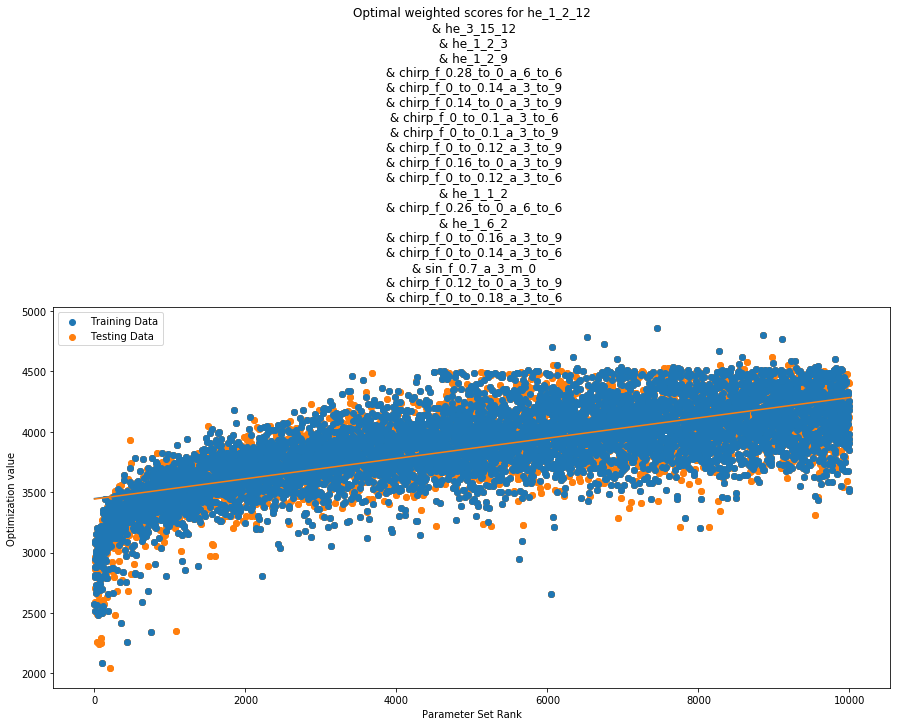

In [15]:
weight_list, stim_list = trainAndValidateScoreOptimization(stimsInOrder[:k], True, seed=seed, saveToFile=True)

In [16]:
opt_result_hdf5 = h5py.File('./optimization_results_path/multi_stim_bbp_full.hdf5', 'w')
ordered_score_function_list_as_binary = np.array([np.string_(e) for e in score_function_list])
opt_result_hdf5.create_dataset('ordered_score_function_list', data=ordered_score_function_list_as_binary)
opt_result_hdf5.create_dataset('opt_stim_name_list', data=stim_list)
opt_result_hdf5.create_dataset('opt_weight_list', data=weight_list[0])
opt_result_hdf5.close()
